In [2]:
import os 

os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [8]:
import json
from functools import partial
from itertools import product
from typing import Optional, Literal, Callable
from tqdm import tqdm
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from collections import defaultdict

import submitit
from submitit.core.utils import CommandFunction
import nevergrad as ng
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from losses.loss_types import LossType
from utils.exp_utils import get_executor, get_executor_local, run_experiments
from utils.utils import conf_to_args

In [9]:
SCRIPT_NAME = "spur_corr_exp.py"
EXP_DIR = Path("output/gt_probe_cifar_mnist_exps")
EXP_DIR.mkdir(parents=True, exist_ok=True)



In [67]:
seeds = list(range(1, 5))

# TODO: add aux weights based on tuining
method_configs = {
    "DivDis": {"loss_type": LossType.DIVDIS, "aux_weight": 1.5},
    "TopK 0.1": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.1, "aux_weight": 1.5},
    "TopK 0.5": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.5, "aux_weight": 1.0},
    # "DBAT": {"loss_type": LossType.DBAT, "shared_backbone": False, "freeze_heads": True, "binary": True, "batch_size": 16, "target_batch_size": 32},
    # "ERM": {"loss_type": LossType.ERM, "aux_weight": 0.0},
}

dataset_configs = {
    "cifar_mnist": {"dataset": "cifar_mnist", "model": "Resnet50", "epochs": 5, "mix_rate": 0.5},
}

configs = {
    (ds_name, method_name, seed): {**ds_config, **method_config, "seed": seed} 
    for (ds_name, ds_config), (method_name, method_config) in product(dataset_configs.items(), method_configs.items())
    for seed in seeds
}

def get_conf_dir(ds_name, method_name, seed):
    return f"{EXP_DIR}/{ds_name}_{method_name}/{seed}"

for (ds_name, method_name, seed), conf in configs.items():
    exp_dir = get_conf_dir(ds_name, method_name, seed)
    conf["exp_dir"] = exp_dir
    conf["plot_activations"] = True

# Run Experiments

In [61]:
executor = get_executor(EXP_DIR, mem_gb=16)
jobs = run_experiments(executor, list(configs.values()), SCRIPT_NAME)

In [63]:
len(jobs)

12

# Process Results

In [68]:
from typing import Literal
def get_exp_metrics(conf: dict):
    if not (Path(conf["exp_dir"]) / "metrics.json").exists():
        raise FileNotFoundError(f"Metrics file not found for experiment {conf['exp_dir']}")
    with open(Path(conf["exp_dir"]) / "metrics.json", "r") as f:
        exp_metrics = json.load(f)
    return exp_metrics

# we want average probe accuracy per epoch

In [69]:
exps_by_method = defaultdict(list)
for (ds_name, method_name, seed), conf in configs.items():
    exps_by_method[method_name].append(conf)

In [70]:
# get average accs (by val loss) for each experiment
acc_results = defaultdict(list)
for method_name, exps in exps_by_method.items():
    for conf in exps:
        exp_metrics = get_exp_metrics(conf)
        acc_results[method_name].append(exp_metrics["test_probe_acc"])
        

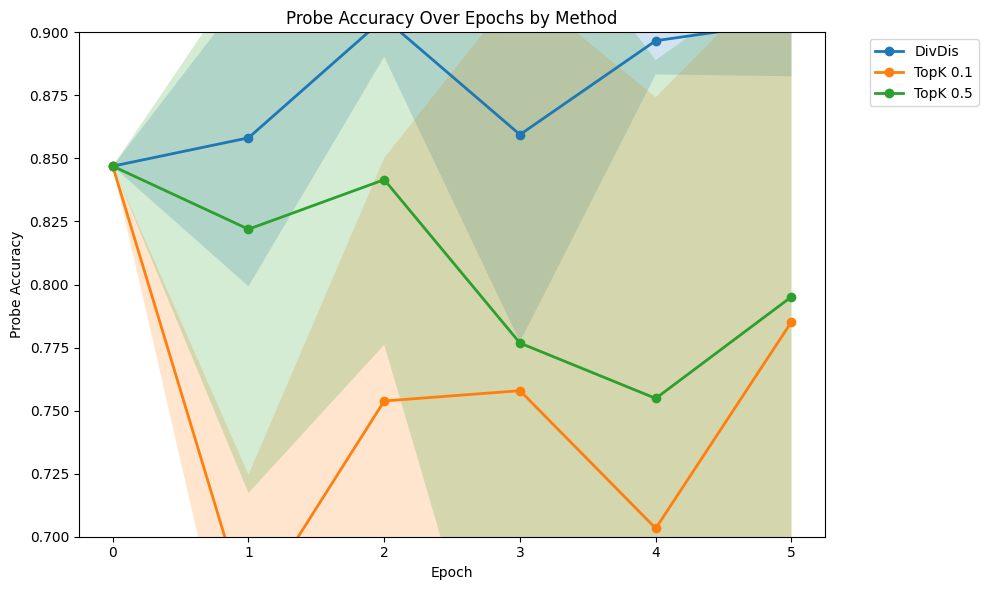

In [71]:
# Calculate mean and std of accuracies for each method
mean_accs = {}
std_accs = {}
for method_name, accs in acc_results.items():
    accs_array = np.array(accs)
    mean_accs[method_name] = np.mean(accs_array, axis=0)
    std_accs[method_name] = np.std(accs_array, axis=0)

# Create plot
plt.figure(figsize=(10, 6))

# Plot each method
for method_name in mean_accs.keys():
    epochs = np.arange(len(mean_accs[method_name]))
    plt.plot(epochs, mean_accs[method_name], marker='o', label=method_name, linewidth=2)
    plt.fill_between(
        epochs,
        mean_accs[method_name] - std_accs[method_name],
        mean_accs[method_name] + std_accs[method_name],
        alpha=0.2
    )

# Customize plot
plt.xlabel('Epoch')
plt.ylabel('Probe Accuracy')
plt.title('Probe Accuracy Over Epochs by Method')
# plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0.7, 0.9)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

In [ ]:
# help, noting that significant here I guess